## 흉부 x-ray 사진을 인경신공망 학습을 이용하여 폐렴 환자 구분 하기

### 기본 라이브러리 임포트

In [1]:
########################################
##### 기본적으로 필요한 라이브러리 import #####
########################################
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import skimage
import numpy as np
from glob import glob
import matplotlib.cm as cm

########################################
##### 머신러닝 관련 라이브러리 import #####
########################################
import sklearn
import scipy
from skimage.transform import resize
import keras.models as km
import keras.layers as kl

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 데이터 경로 설정

In [2]:
train_dir = "../chest_xray/train/"
test_dir =  "../chest_xray/test/" 

### 데이터 크기 설정

In [3]:
# 데이터 크기 (150 x 150)
_N_ROW = 150  # 세로 150
_N_COL = 150  # 가로 150
_N_PIXEL = _N_ROW * _N_COL

### 폴더에 있는 데이터를 읽어서, 추가 및 라벨링을 하는 함수 get_data 설정 

In [4]:
def get_data(folder):
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        print( 'foldername = ' + folderName )
        
        if folderName.startswith('.'):
            continue
        
        if folderName == 'NORMAL':
            label = 0
        elif folderName == 'PNEUMONIA':
            label = 1
        else:
            print("Err! I don't know this data...")
            return
 
        for image_filename in tqdm(os.listdir(folder + folderName)):
            try:
                # 흑백으로 된 이미지를 읽는다.  
                img_file = cv2.imread(folder + folderName + '/' + image_filename, 0 )

                # 히스토그램 equlization 적용 
                hist, bins = np.histogram(img_file.flatten(), 256,[0,256]) 
                cdf = hist.cumsum()

                # cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
                # mask처리가 되면 Numpy 계산에서 제외가 됨
                # 아래는 cdf array에서 값이 0인 부분을 mask처리함
                cdf_m = np.ma.masked_equal(cdf,0)

                #History Equalization 공식
                cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

                # Mask처리를 했던 부분을 다시 0으로 변환
                cdf = np.ma.filled(cdf_m,0).astype('uint8')

                img_file = cdf[img_file]

                if img_file is not None: 
                    img_file = skimage.transform.resize(img_file, (_N_ROW, _N_COL))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
            except:
                continue
                    
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

### 학습 데이터를 읽어오고 라벨도 읽어온다. 

In [5]:
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

  0%|          | 0/3876 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  0%|          | 2/3876 [00:00<04:15, 15.15it/s]

foldername = .DS_Store
foldername = PNEUMONIA


  0%|          | 1/1342 [00:00<04:16,  5.23it/s]

foldername = NORMAL


  1%|          | 4/390 [00:00<00:10, 38.11it/s]

foldername = .DS_Store
foldername = PNEUMONIA


  0%|          | 1/234 [00:00<00:27,  8.46it/s]

foldername = NORMAL


100%|██████████| 234/234 [00:22<00:00, 10.38it/s]


### 이미지를 보여주는 함수 정의 

In [6]:
def show_img(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
    plt.imshow(a, cmap=cm.gray)

### 비정상의 폐

1


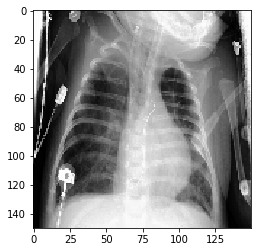

In [7]:
show_img(X_train[0])
print(y_train[0])

In [8]:
np.shape(X_test[0])

(150, 150)

1


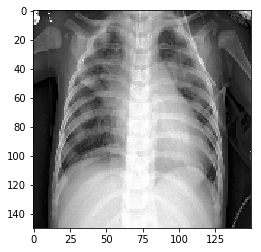

In [9]:
show_img(X_test[0])
print(y_test[0])

### 정상인의 폐

1


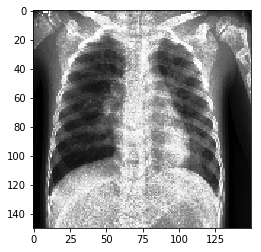

In [10]:
show_img(X_train[1040])
print(y_train[1040])

0


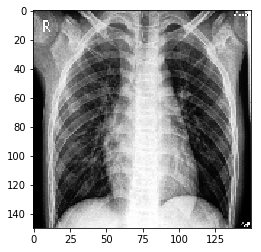

In [11]:
show_img(X_test[623])
print(y_test[623])

### 환자의 폐

비정상!!


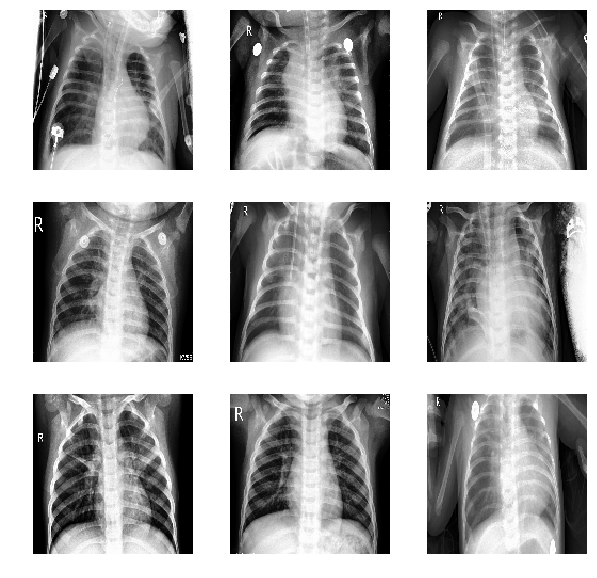

In [12]:
print("비정상!!")
multipleImages = glob('../chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:9]:
    im = cv2.imread(l, 0)
    # 흑백으로 된 이미지를 읽는다.  

    # 히스토그램 equlization 적용 
    hist, bins = np.histogram(im.flatten(), 256,[0,256]) 
    cdf = hist.cumsum()

    # cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
    # mask처리가 되면 Numpy 계산에서 제외가 됨
    # 아래는 cdf array에서 값이 0인 부분을 mask처리함
    cdf_m = np.ma.masked_equal(cdf,0)

    #History Equalization 공식
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

    # Mask처리를 했던 부분을 다시 0으로 변환
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    im = cdf[im]
                
                
    im = cv2.resize(im, (_N_ROW , _N_COL)) 
    plt.subplot(3, 3, i_+1) #.set_title(l)
    plt.imshow(im,  cmap=cm.gray); 
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    plt.axis('off')
    i_ += 1

### 정상인의 폐

정상!!


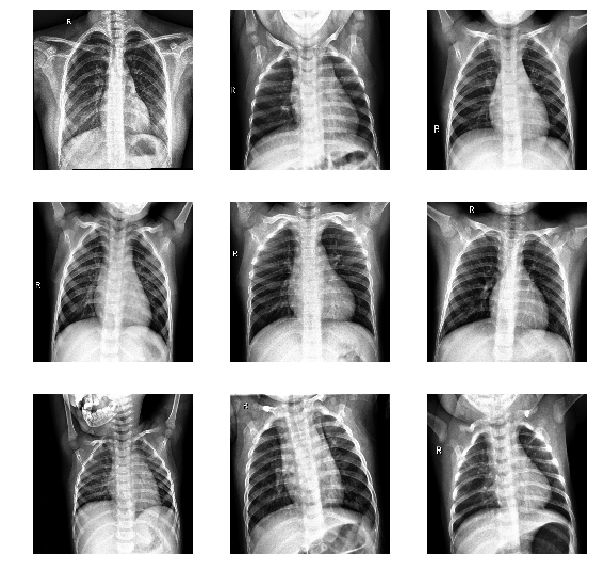

In [13]:
print("정상!!")
multipleImages = glob('../chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:9]:
    im = cv2.imread(l, 0)
    # 흑백으로 된 이미지를 읽는다.  

    # 히스토그램 equlization 적용 
    hist, bins = np.histogram(im.flatten(), 256,[0,256]) 
    cdf = hist.cumsum()

    # cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
    # mask처리가 되면 Numpy 계산에서 제외가 됨
    # 아래는 cdf array에서 값이 0인 부분을 mask처리함
    cdf_m = np.ma.masked_equal(cdf,0)

    #History Equalization 공식
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

    # Mask처리를 했던 부분을 다시 0으로 변환
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    im = cdf[im]
                
                
    im = cv2.resize(im, (_N_ROW , _N_COL)) 
    plt.subplot(3, 3, i_+1) #.set_title(l)
    plt.imshow(im,  cmap=cm.gray); 
#     plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    plt.axis('off')
    i_ += 1

### 에러 확인 함수 생성

In [14]:
def confirmErr(realAnswerList, testAnswerList):
    answerNum = 0
    for i, eachAns in enumerate(realAnswerList):
        if testAnswerList[i] == eachAns:
            answerNum += 1
    return float(len(realAnswerList)-answerNum)/float(len(realAnswerList))*100

### 크기 재조정 

In [15]:
np.shape(X_test)

(624, 150, 150)

In [16]:
np.shape(X_test)

(624, 150, 150)

In [17]:
np.shape(y_test)

(624,)

In [18]:
X_test = X_test.reshape( (np.shape(X_test)[0], np.shape(X_test)[1],np.shape(X_test)[2], 1) )
X_train = X_train.reshape( (np.shape(X_train)[0], np.shape(X_train)[1],np.shape(X_train)[2], 1) )

In [19]:
np.shape(X_test)

(624, 150, 150, 1)

### 학습 모델을 설정한다.

In [25]:
def study(trDataList, trLabelList, save_h5_name, log_txt_name):
    trDataList = X_train
    trLabelList = y_trainHot

    # 모델 설정
    model = km.Sequential()
    model.add(kl.Conv2D(input_shape=(_N_ROW, _N_COL, 1), filters=16, kernel_size=(3, 3), strides=1  ))
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Activation('relu'))
    model.add(kl.Conv2D(filters=20, kernel_size=(3, 3), strides=1  ))
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Activation('relu'))
    model.add(kl.Conv2D(filters=24, kernel_size=(3, 3), strides=1  ))
    model.add(kl.Activation('relu'))
    model.add(kl.Flatten())
    model.add(kl.Dense(2, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 모델 출력 
    print(model.summary())
    print('\n\n\n')

    # 학습 데이터를 추출하여 저장하고 출력한다
    history_callback = model.fit(trDataList, trLabelList, epochs=5, batch_size=150, verbose=2)
    loss_history = history_callback.history
    train_log = ''
    for i in range(len(loss_history['acc'])):
        train_log += "%d epoch _ acc : %.4f, loss : %.4f\n" % ( i+1, loss_history['acc'][i], loss_history['loss'][i] )

    # 로그 기록 
    fd = open(log_txt_name, 'w')
    fd.write(train_log)
    fd.close()

    # 모델 저장 
    km.save_model(model, save_h5_name) 

    # 실제 에러율 확인 
    print ('err is  %f%%' % (confirmErr(np.argmax(trLabelList, axis=1),  np.argmax(model.predict(trDataList), axis=1))) )
    
    return model

### 학습 수행 

In [26]:
_model = study(trDataList = X_test, trLabelList = y_testHot, save_h5_name= 'model_plus_layer_histogram_3.h5', log_txt_name='train_log_plus_layer_histogram_3.txt')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 20)        2900      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 20)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 36, 36, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 24)        4344      
__________

### 학습 결과를 test set 으로 확인

In [27]:
trDataList = X_test
trLabelList = y_testHot

# 실제 에러율 확인
print ('The real err is  %f%%' % (confirmErr(np.argmax(trLabelList, axis=1), np.argmax(_model.predict(trDataList), axis=1))) )

The real err is  23.557692%
